## Notebook 7 - Duplication Analysis with Groups
Using 0.5 Jaccard Distance obtained in Notebook 6

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
#pip install -U regex

In [4]:
## Adding ML and NLP packages

import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
StopWords = stopwords.words("english")

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [7]:
pd.set_option("max_colwidth", 200)

In [8]:
from google.cloud import storage
# !pip install gcsfs --upgrade

### Setting Up Helper Functions

In [9]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Accessing Filtered Database

In [10]:
# Out of 27 million data entries, we only have ~3.8 million new tweets
# twitter_df7_tweets.count()

### Analyzing Posts from verified users

In [11]:
twitter_df7_ver=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kshitijm/Final_Project-FiltData4_Ver_Users_2')
twitter_df7_ver.limit(10)

23/03/09 19:37:36 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1539335995845402624,Tue Jun 21 19:54:...,RT @NSEAOnline: P...,public dollars sh...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1539262288053833728,1539316518202138624,NSEAOnline,22789766,NEAToday,official account ...,Washington DC,true,247738,11834,4148,8048,27669,Wed Mar 04 15:51:...,https://pbs.twimg...,[],retweet,false,false,false,true,false,social_media_infl...,Educational_Inst
1539336083649048577,Tue Jun 21 19:54:...,RT @JasonBedrick:...,@wajahatali what ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539289355449028608,JasonBedrick,640893,EWErickson,you can listen ev...,"Atlanta, GA",true,205722,2700,4633,1384,14273,Mon Jan 15 22:54:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336297814319104,Tue Jun 21 19:55:...,RT @itsSpencerBro...,scotus handed a b...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539328635613630464,itsSpencerBrown,48459553,KatiePavlich,proud american wo...,On Instagram/Off ...,true,947092,2009,4472,18188,55802,Thu Jun 18 19:29:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336371936051200,Tue Jun 21 19:56:...,One of Louisiana'...,one of louisiana'...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,44426926,FOX8NOLA,wvue - fox 8 is y...,New Orleans,true,217913,2853,1241,1350,207940,Wed Jun 03 18:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539336396971859968,Tue Jun 21 19:56:...,@hales_ted But th...,@hales_ted but th...,null,null,null,null,null,true,false,,0,0,0,0,1539335979336470528,1445063896725819398,hales_ted,null,null,null,738538436,AoDespair,author journalist...,"Baltimore, MD",true,334054,610,2732,5818,97431,Sun Aug 05 12:53:...,https://pbs.twimg...,[],reply,false,true,true,false,false,social_media_infl...,News_Journalist
1539336533509132289,Tue Jun 21 19:56:...,Congratulations t...,congratulations t...,null,null,null,null,null,true,false,,0,0,0,0,1539329196379541509,16240525,ASBMB,null,null,null,16240525,ASBMB,american society ...,"Rockville, Maryland",true,24963,4259,0,14868,40004,Thu Sep 11 14:05:...,https://pbs.twimg...,[],reply,false,false,false,false,true,micro_influencer,Research_Inst
1539336550730842115,Tue Jun 21 19:56:...,.@JimGrossmanAHA ...,.@jimgrossmanaha ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76944176,AHAhistorians,the american hist...,"Washington, D.C.",true,55451,2362,1105,8000,32842,Thu Sep 24 13:54:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...,Influencer
1539336562814623745,Tue Jun 21 19:56:...,RT @FOX8NOLA: One...,one of louisiana'...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539336371936051200,FOX8NOLA,30950114,jessecbrooks,digital content p...,"New Orleans, LA",true,3442,1741,71,46045,82432,Mon Apr 13 20:23:...,https://pbs.twimg...,[],retweet,false,false,true,false,false,not_influencer,News_Journalist
1539336614966599681,Tue Jun 21 19:57:...,Graduation 2022: ...,graduation 2022: ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16477702,syracusedotcom,syracuse and cent...,"Syracuse, NY",true,102116,589,829,190,227817,Sat Sep 27 00:17:...,https://pbs.twimg...,[],ori

In [12]:
twitter_df7_ver.count()

577459

In [13]:
twitter_df7_ver.select('tweet_type').groupBy('tweet_type').count()

tweet_type,count
retweet,221923
reply,59486
quote,23552
original_tweet,272498


In [1]:
# We have 270K original tweets from our verified users, we will look at these

In [15]:
twitter_df7_ver_orig=twitter_df7_ver.filter(col('tweet_type')=='original_tweet')
twitter_df7_ver_orig.limit(10)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1539336371936051200,Tue Jun 21 19:56:...,One of Louisiana'...,one of louisiana'...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,44426926,FOX8NOLA,wvue - fox 8 is y...,New Orleans,true,217913,2853,1241,1350,207940,Wed Jun 03 18:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539336550730842115,Tue Jun 21 19:56:...,.@JimGrossmanAHA ...,.@jimgrossmanaha ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76944176,AHAhistorians,the american hist...,"Washington, D.C.",true,55451,2362,1105,8000,32842,Thu Sep 24 13:54:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...,Influencer
1539336614966599681,Tue Jun 21 19:57:...,Graduation 2022: ...,graduation 2022: ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16477702,syracusedotcom,syracuse and cent...,"Syracuse, NY",true,102116,589,829,190,227817,Sat Sep 27 00:17:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539336871049846784,Tue Jun 21 19:58:...,New York families...,new york families...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1668256296,wealth,helping you manag...,null,true,80526,1530,895,185,28156,Tue Aug 13 16:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1527065374851743745,Wed May 18 23:15:...,🎓 The @SamChampi...,🎓 the @samchampi...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,72585833,BoerneISD,award-winning sch...,"Boerne, TX",true,6366,377,93,24375,20355,Tue Sep 08 15:52:...,https://pbs.twimg...,[],original_tweet,true,true,false,true,false,micro_influencer,Educational_Inst
1527065651810078720,Wed May 18 23:16:...,Day 1 of State Tr...,day 1 of state tr...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,743900947,NicoleWeavingTV,jersey girl | pro...,"Lincoln, NE",true,1163,1108,12,20860,8022,Tue Aug 07 22:42:...,https://pbs.twimg...,[],original_tweet,false,true,true,true,true,not_influencer,Educational_Inst
1530319226434723840,Fri May 27 22:45:...,Texas School Shoo...,texas school shoo...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,22630309,InsideEdition,inside edition is...,null,true,89968,721,603,7446,59806,Tue Mar 03 14:49:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1530319227332317185,Fri May 27 22:45:...,After a gunman ki...,after a gunman ki...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,8940342,HoustonChron,news headlines an...,"Houston, TX",true,669193,156,5231,444,307465,Mon Sep 17 22:42:...,https://pbs.twimg...,[],original_tweet,false,true,true,false,false,social_media_infl...,News_Journalist
1530319424510513154,Fri May 27 22:45:...,Glorious. A press...,glorious. a press...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,108557666,ClaraDFMarques,columnist editor...,Singapore,true,5637,781,138,5546,8119,Tue Jan 26 09:15:...,https://pbs.twimg...,[],original_tweet,false,false,true,false,false,micro_influencer,News_Journalist
1530319692539338752,Fri May 27 22:47:...,Live updates: Tex...,live updates: tex...,null,null,nu

### Testing the code on a sample

In [16]:
df7_smpl = twitter_df7_ver_orig.sample(withReplacement=True, fraction=0.05, seed=3)
df7_grp_1 = df7_smpl.orderBy('id',ascending=False).select('id','account_id','user_type','tweet_text')
df7_grp_1.cache()
df7_grp_1.limit(10)

id,account_id,user_type,tweet_text
1623302649687814145,159045003,Government,early interventio...
1623299555046354949,752010278,News_Journalist,lewis mwandiki wh...
1623298154123739142,2836421,Government,cynthia miller-id...
1623271328483786754,2202772039,Educational_Inst,now be a part of ...
1623270721488056320,1219959734473764867,Educational_Inst,teenager is arres...
1623251951592017920,14372104,Government,just in: #bnnsout...
1623240214775992320,60883062,News_Outlet,this year’s #chil...
1623239768862490624,33444337,News_Outlet,the south african...
1623239192137326593,22020347,News_Outlet,football and midd...
1623199346958245889,30264308,Government,the kern high sch...


In [17]:
df7_grp_1_p=df7_grp_1.toPandas()

In [18]:
df7_grp_1.count()

13695

In [19]:
df7_grp_1.show()

+-------------------+-------------------+----------------+--------------------+
|                 id|         account_id|       user_type|          tweet_text|
+-------------------+-------------------+----------------+--------------------+
|1623302649687814145|          159045003|      Government|early interventio...|
|1623299555046354949|          752010278| News_Journalist|lewis mwandiki wh...|
|1623298154123739142|            2836421|      Government|cynthia miller-id...|
|1623271328483786754|         2202772039|Educational_Inst|now be a part of ...|
|1623270721488056320|1219959734473764867|Educational_Inst|teenager is arres...|
|1623251951592017920|           14372104|      Government|just in: #bnnsout...|
|1623240214775992320|           60883062|     News_Outlet|this year’s #chil...|
|1623239768862490624|           33444337|     News_Outlet|the south african...|
|1623239192137326593|           22020347|     News_Outlet|football and midd...|
|1623199346958245889|           30264308

### Segregating Tweet Text

In [20]:
tweet_text_sample = df7_grp_1.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)
tweet_text_sample.take(10)

['early intervention can help prevent children developing life-long mental health issues. \n\nthis #childrensmentalhealthweek we’re highlighting the need for more investment in:\n▶️counselling\n▶️youth services\n▶️early support hubs\n▶️support services in schools &amp; communities.\n\n1/3🧵',
 'lewis mwandiki who sat for his final primary exams at jeieni junior primary school in tigania west sub county within meru county scored 364 marks. \n\n https://t.co/izs2sezthp',
 'cynthia miller-idriss: extremists are twisting homeschooling education to spread white supremacist ideologies. https://t.co/kqefhp6t7d',
 "now be a part of india's fastest growing university and shape your future by enrolling in cu's advanced ug/pg programs. enter your gateway to excellence with an industry-aligned curriculum and programs offered by chandigarh university.\n\napply 👉https://t.co/jbhpydvmqg https://t.co/1mxvaxourn",
 "teenager is arrested for attending class at his ontario catholic high school after he wa

In [21]:
tokens = tweet_text_sample\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [22]:
tokens.take(5)

[(['early',
   'intervention',
   'help',
   'prevent',
   'children',
   'developing',
   'mental',
   'health',
   'highlighting',
   'need',
   'investment',
   'support',
   'services',
   'schools'],
  0),
 (['lewis',
   'mwandiki',
   'final',
   'primary',
   'exams',
   'jeieni',
   'junior',
   'primary',
   'school',
   'tigania',
   'west',
   'county',
   'within',
   'meru',
   'county',
   'scored'],
  1),
 (['cynthia',
   'extremists',
   'twisting',
   'homeschooling',
   'education',
   'spread',
   'white',
   'supremacist'],
  2),
 (['part',
   'fastest',
   'growing',
   'university',
   'shape',
   'future',
   'enrolling',
   'advanced',
   'enter',
   'gateway',
   'excellence',
   'curriculum',
   'programs',
   'offered',
   'chandigarh'],
  3),
 (['teenager',
   'arrested',
   'attending',
   'class',
   'ontario',
   'catholic',
   'high',
   'school',
   'suspended',
   'challenging',
   'transgender',
   'says',
   'religious'],
  4)]

In [23]:
row = Row('tweet_text_sample')
df_tweet_text_sample=tweet_text_sample.map(row).zipWithIndex().toDF(['tweet_text','id'])
df_tweet_text_sample.show(5)

+--------------------+---+
|          tweet_text| id|
+--------------------+---+
|{early interventi...|  0|
|{lewis mwandiki w...|  1|
|{cynthia miller-i...|  2|
|{now be a part of...|  3|
|{teenager is arre...|  4|
+--------------------+---+
only showing top 5 rows



In [24]:
df_tweet_text_sample.count()

13695

In [28]:
df_tweet_text_sample_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tweet_text_sample_tokens = df_tweet_text_sample_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tweet_text_sample_tokens.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|list_of_words                                                                                                                                                                              |id |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|[early, intervention, help, prevent, children, developing, mental, health, highlighting, need, investment, support, services, schools]                                                     |0  |
|[lewis, mwandiki, final, primary, exams, jeieni, junior, primary, school, tigania, west, county, within, meru, county, scored]                                                             |1  |
|[cynthia, extremists, twistin

In [29]:
df_tweet_text_sample_tokens.count()

13694

#### Step 2. Fit countvectorizer to create word features

In [30]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_tweet_text_sample_vectorize = vectorize.fit(df_tweet_text_sample_tokens).transform(df_tweet_text_sample_tokens)

In [31]:
df_tweet_text_sample_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[early, intervention, help, prevent, children, developing, mental, health, highlighting, need, investment, support, services, schools]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[lewis, mwandiki, final, primary, exams, jeieni, junior, primary, school, tigania, west, county, within, meru, county, scored]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[cynthia, extremists, twisting, homeschooling, education, spread, white, supremacist]",2,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[part, fastest, growing, university, shape, future, enrolling, advanced, enter, gateway, excellence, curriculum, programs, offered, chandigarh]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[teenager, arrested, attending, class, ontario, catholic, high, school, suspended, challenging, transgender, says, religious]",4,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Step 3. Fit MinHashLSH to create hash table

In [32]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_text_sample_vectorize)
df_hashed = mh.fit(df_tweet_text_sample_vectorize).transform(df_tweet_text_sample_vectorize)

In [33]:
df_hashed.limit(10).toPandas()

,list_of_words,id,features,hashes
0,"[early, intervention, help, prevent, children, developing, mental, health, highlighting, need, investment, support, services, schools]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[17167334.0], [17063584.0], [472756446.0], [95229655.0], [231967258.0]]"
1,"[lewis, mwandiki, final, primary, exams, jeieni, junior, primary, school, tigania, west, county, within, meru, county, scored]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [58811264.0], [140540522.0], [54865815.0], [56996485.0]]"
2,"[cynthia, extremists, twisting, homeschooling, education, spread, white, supremacist]",2,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[234656790.0], [591825324.0], [333741076.0], [404041988.0], [157201102.0]]"
3,"[part, fastest, growing, university, shape, future, enrolling, advanced, enter, gateway, excellence, curriculum, programs, offered, chandigarh]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[115564298.0], [230522037.0], [13099276.0], [183575181.0], [200065035.0]]"
4,"[teenager, arrested, attending, class, ontario, catholic, high, school, suspended, challenging, transgender, says, religious]",4,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [50611523.0], [10600358.0], [461219945.0], [24451698.0]]"
5,"[report, panel, literacy, levels, among, school, children, south, africa, found, grade, pupils, read]",5,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[16660839.0], [186285538.0], [229973038.0], [46022440.0], [101788110.0]]"
6,"[february, theme, free, school, resources, help, pupils, explore, connect, others, rewarding, meaningful, learn]",6,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[[16660839.0], [17063584.0], [102992025.0], [46022440.0], [102216486.0]]"
7,"[south, african, democratic, union, raised, concerns, increasing, incidents, violence]",7,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[513188388.0], [229352525.0], [58144527.0], [351422858.0], [863635989.0]]"
8,"[football, middle, east, conflict, drive, schools]",8,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[110016442.0], [558277385.0], [216755735.0], [170966995.0], [472884357.0]]"
9,"[kern, high, school, district, board, meeting, upset, angered, community, members, even, child, make, stance, olivia, garrison, teacher, would, help, gender, transition, leaving, parents]",9,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [17063584.0], [30854182.0],

In [34]:
df_hashed.count()

13694

In [35]:
df_hashed_tweet_text_samp = df_tweet_text_sample.join(df_hashed, "id", how = 'left').cache()
df_hashed_tweet_text_samp.limit(5).toPandas()

,id,tweet_text,list_of_words,features,hashes
0,26,"(nassp president @aarondhuff shares how his school weaves #blackhistorymonth information throughout his school all year long.\n\nhttps://t.co/pne6migods,)","[nassp, president, shares, school, weaves, information, throughout, school, year]","(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [58185770.0], [801157480.0], [220174210.0], [127781102.0]]"
1,29,"(session daily: governor’s energy proposals seek to unlock federal funds, grow solar for schools https://t.co/clwjgpjme3 \n\n#mnleg #mnhouse,)","[session, energy, proposals, seek, unlock, federal, grow, solar, schools]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[452130520.0], [75578655.0], [26974565.0], [87435361.0], [278686575.0]]"
2,474,"(woman arrested for posing as high school student is rutgers graduate https://t.co/rj3dzfqnot,)","[woman, arrested, posing, high, school, student, rutgers, graduate]","(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[47945584.0], [446945008.0], [30854182.0], [461219945.0], [338509482.0]]"
3,964,"(space race: astrophysics is racist, according to woke professor\nhttps://t.co/l1go9uc7mb,)","[space, astrophysics, according, woke]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1220130189.0], [463875351.0], [202880446.0], [1343969413.0], [140884692.0]]"
4,1677,"(https://t.co/fpiyndngb3 \nit is our pleasure to share that dr. neelakandan rajamohan, assistant professor in the school of electrical sciences &amp; an expert on 5g technology, participated in th...","[pleasure, share, neelakandan, assistant, professor, school, electrical, sciences, expert, participated, panel, discussion, technology]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[[47945584.0], [287242102.0], [180127704.0], [299676361.0], [121443495.0]]"


### Step 4. Establish similarity threshold and return near-duplicate records
**Note:** Using 0.5 distance obtained from notebook 6 analysis

#### 0.5 Distance

In [36]:
jaccard_distance = 0.5

df_dups_tweet_text = model.approxSimilarityJoin(df_hashed_tweet_text_samp, df_hashed_tweet_text_samp, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [37]:
df_dups_50_tweet_text = df_dups_tweet_text
df_dups_50_tweet_text.cache()
df_dups_50_tweet_text.limit(5).toPandas()

,distCol,id_A,id_B,tweet_text_A,tweet_text_B
0,0.000000,6081,10171,"(train for a rewarding career in health care. with a few hours a day and a few days a week, now is the perfect time to start training for a new career. enter at https://t.co/julhfahyzi for a chanc...","(train for a rewarding career in health care. with a few hours a day and a few days a week, now is the perfect time to start training for a new career. enter at https://t.co/julhfappla for a chanc..."
1,0.428571,4024,4943,"(here’s who you voted the week 10 athens-area high school football player of the week\n\nhttps://t.co/elx3wocct5 @sammybrown_ @jeffersonfootba @jhs_prospects @rynedennis,)","(week 8 high school football scoreboard https://t.co/etflypyt8x via @themarionstar,)"
2,0.444444,1970,6198,"(who’s the best high school football player of 2022 in bradenton, manatee? vote now https://t.co/wept7ae9ij,)","(two return tds in one half: vote for the high school football d/st player of the week https://t.co/6v4bt1dfak,)"
3,0.000000,12515,12516,"(stay with #news12 for updates on school threats at #newburgh schools. i’m live at noon with with latest. https://t.co/3wbqcck2fm,)","(stay with #news12 for updates on school threats at #newburgh schools. i’m live at noon with with latest. https://t.co/3wbqcck2fm,)"
4,0.000000,11139,11140,"(some high school students in montana used an old law to pull a senior prank straight out of the old west. https://t.co/mdnyyd6gka,)","(some high school students in montana used an old law to pull a senior prank straight out of the old west. https://t.co/mdnyyd6gka,)"


In [38]:
records = df_hashed_tweet_text_samp.count()
dups_50 = df_dups_50_tweet_text.select('id_A').distinct().count()
uniques_50 = records - dups_50

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_50)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', ': ', uniques_50)

Total records:  13695
Duplicate titles based on { 0.5 } jaccard distance:  825
Unique titles based on { 0.5 } jaccard distance:  :  12870


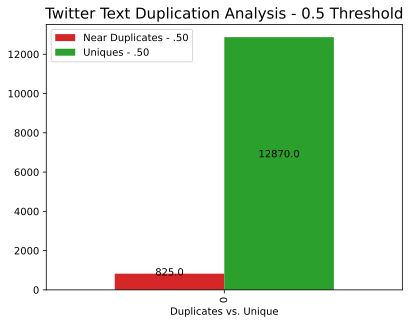

In [39]:
dups_df = pd.DataFrame.from_dict({'Near Duplicates - .50': [dups_50], 'Uniques - .50': [uniques_50]})

ax=dups_df.plot(kind = 'bar',y=['Near Duplicates - .50', 'Uniques - .50'], fontsize=10, color=['C3', 'C2'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Twitter Text Duplication Analysis - 0.5 Threshold', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

--------------
### Adding Groups to Duplicated

In [40]:
# Verifying sequence of sample data
df7_grp_1.limit(10)

id,account_id,user_type,tweet_text
1623302649687814145,159045003,Government,early interventio...
1623299555046354949,752010278,News_Journalist,lewis mwandiki wh...
1623298154123739142,2836421,Government,cynthia miller-id...
1623271328483786754,2202772039,Educational_Inst,now be a part of ...
1623270721488056320,1219959734473764867,Educational_Inst,teenager is arres...
1623251951592017920,14372104,Government,just in: #bnnsout...
1623240214775992320,60883062,News_Outlet,this year’s #chil...
1623239768862490624,33444337,News_Outlet,the south african...
1623239192137326593,22020347,News_Outlet,football and midd...
1623199346958245889,30264308,Government,the kern high sch...


In [41]:
## Using duplicates as per 0.5 Jaccard Distance
dups_50 = df_dups_50_tweet_text.select(col('id_A').alias('id_analysis')).distinct().withColumn('is_dups',lit('Near_Dups'))
dups_50.cache()
dups_50.limit(10)

id_analysis,is_dups
11860,Near_Dups
11309,Near_Dups
191,Near_Dups
6834,Near_Dups
13299,Near_Dups
12422,Near_Dups
720,Near_Dups
2598,Near_Dups
3120,Near_Dups
13527,Near_Dups


-------

In [42]:
df7_grp_1.limit(10)

id,account_id,user_type,tweet_text
1623302649687814145,159045003,Government,early interventio...
1623299555046354949,752010278,News_Journalist,lewis mwandiki wh...
1623298154123739142,2836421,Government,cynthia miller-id...
1623271328483786754,2202772039,Educational_Inst,now be a part of ...
1623270721488056320,1219959734473764867,Educational_Inst,teenager is arres...
1623251951592017920,14372104,Government,just in: #bnnsout...
1623240214775992320,60883062,News_Outlet,this year’s #chil...
1623239768862490624,33444337,News_Outlet,the south african...
1623239192137326593,22020347,News_Outlet,football and midd...
1623199346958245889,30264308,Government,the kern high sch...


In [43]:
df7_grp_1.count()

13695

In [44]:
# df7_final = df7_grp_1.select('user_type').rdd.zipWithIndex().toDF(['org_type','id_analysis'])
# df7_final.limit(10)

df7_final=df7_grp_1.rdd.map(lambda x : x['user_type']).zipWithIndex().toDF(['org_type','id_analysis'])
df7_final.show(10)

+----------------+-----------+
|        org_type|id_analysis|
+----------------+-----------+
|      Government|          0|
| News_Journalist|          1|
|      Government|          2|
|Educational_Inst|          3|
|Educational_Inst|          4|
|      Government|          5|
|     News_Outlet|          6|
|     News_Outlet|          7|
|     News_Outlet|          8|
|      Government|          9|
+----------------+-----------+
only showing top 10 rows



In [45]:
df7_final.cache()

org_type,id_analysis
Government,0
News_Journalist,1
Government,2
Educational_Inst,3
Educational_Inst,4
Government,5
News_Outlet,6
News_Outlet,7
News_Outlet,8
Government,9


In [50]:
df7_final1 = df7_final.join(dups_50,'id_analysis','left')\
.na.fill(value='Unique',subset=['is_dups'])\

df7_final1.limit(20)

id_analysis,org_type,is_dups
0,Government,Unique
1,News_Journalist,Unique
2,Government,Unique
3,Educational_Inst,Unique
4,Educational_Inst,Unique
5,Government,Unique
6,News_Outlet,Unique
7,News_Outlet,Unique
8,News_Outlet,Unique
9,Government,Unique


In [49]:
df7_final1.count()

13695

In [53]:
df7_plt = df7_final1.groupBy('org_type','is_dups').agg(count('*').alias('count')).orderBy('org_type')
df7_plt.show()

+----------------+---------+-----+
|        org_type|  is_dups|count|
+----------------+---------+-----+
|Educational_Inst|   Unique| 2643|
|Educational_Inst|Near_Dups|  151|
|      Government|   Unique| 1893|
|      Government|Near_Dups|  118|
|      Influencer|Near_Dups|   33|
|      Influencer|   Unique|  725|
|Micro_Influencer|Near_Dups|   36|
|Micro_Influencer|   Unique|  717|
| News_Journalist|Near_Dups|   69|
| News_Journalist|   Unique| 1271|
|     News_Outlet|   Unique| 5160|
|     News_Outlet|Near_Dups|  387|
|          Others|Near_Dups|   11|
|          Others|   Unique|  180|
|   Research_Inst|   Unique|  281|
|   Research_Inst|Near_Dups|   20|
+----------------+---------+-----+



In [54]:
df7_final1_p=df7_final1.toPandas()

In [55]:
df7_final1_p

,id_analysis,org_type,is_dups
0,0,Government,Unique
1,1,News_Journalist,Unique
2,2,Government,Unique
3,3,Educational_Inst,Unique
4,4,Educational_Inst,Unique
...,...,...,...
13690,13690,News_Outlet,Unique
13691,13691,News_Outlet,Unique
13692,13692,Educational_Inst,Unique
13693,13693,News_Journalist,Unique


In [73]:
crosstab_perc = np.round((pd.crosstab(df7_final1_p['org_type'], df7_final1_p['is_dups'],normalize='index')),3)
crosstab_perc

is_dups,Near_Dups,Unique
org_type,,
Educational_Inst,0.054,0.946
Government,0.059,0.941
Influencer,0.044,0.956
Micro_Influencer,0.048,0.952
News_Journalist,0.051,0.949
News_Outlet,0.070,0.930
Others,0.058,0.942
Research_Inst,0.066,0.934


In [68]:
crosstab = pd.crosstab(df7_final1_p['org_type'], df7_final1_p['is_dups'])

In [69]:
crosstab

is_dups,Near_Dups,Unique
org_type,,
Educational_Inst,151,2643
Government,118,1893
Influencer,33,725
Micro_Influencer,36,717
News_Journalist,69,1271
News_Outlet,387,5160
Others,11,180
Research_Inst,20,281


Text(50.58159722222221, 0.5, 'Different Organisations')

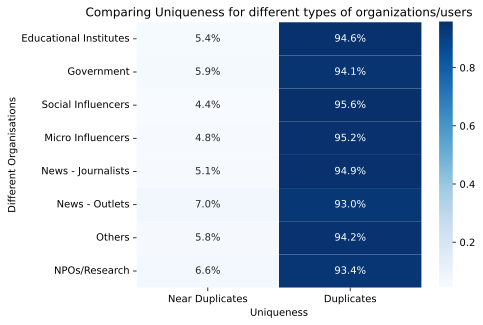

In [77]:
ax=sns.heatmap(crosstab_perc, cmap='Blues', annot=True, fmt='.1%')
ax.set_yticklabels(['Educational Institutes','Government','Social Influencers','Micro Influencers','News - Journalists','News - Outlets','Others','NPOs/Research'])
ax.set_xticklabels(['Near Duplicates','Duplicates'])
ax.set_title('Comparing Uniqueness for different types of organizations/users')
ax.set_xlabel('Uniqueness')
ax.set_ylabel('Different Organisations')